# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


In [2]:
import celloracle as co
co.__version__

'0.5.0'

In [7]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300


## 0.1. Check installation

Celloracle uses some R libraries in network analysis. 
Please make sure that all dependent R libraries are installed on your computer.
You can test the installation with the following command.

In [4]:
co.network_analysis.test_R_libraries_installation()

R path: /usr/bin/R
checking R library installation: igraph -> OK
checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK


## 0.2. Make a folder to save graph

In [5]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)
Please refer to the previous notebook in the tutorial for an example of how to process scRNA-seq data.

In [6]:
# Load data. !!Replace the data path below when you use another data.
adata = sc.read_h5ad("../03_scRNA-seq_data_preprocessing/data/Paul_etal_15.h5ad")

/home/k/anaconda3/envs/pandas1/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/k/anaconda3/envs/pandas1/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


## 1.2. Load TF data. 
For the GRN inference, celloracle needs TF information, which contains lists of the regulatory candidate genes. 
There are several ways to make such TF information. We can generate TF information from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial for the details of this process.


If you do not have your scATAC-seq data, you can use some built-in data in celloracle. The built-in TFinfo wqs made using various tissue/cell-types from the mouse ATAC-seq atlas dataset (http://atlas.gs.washington.edu/mouse-atac/).

You can load and use the data with the following command. 

In [11]:
# Load TF info which was made from mouse cell atlas dataset.
TFinfo_df = co.data.load_TFinfo_df_mm9_mouse_atac_atlas()

# Check data
TFinfo_df.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Initiate Oracle object

Celloracle has a custom called Oracle. We can use Oracle for the data preprocessing and GRN inference steps.
The Oracle object stores all of necessary information and does the calculations with its internal functions.
We instantiate an Oracle object, then input the gene expression data (anndata) and a TFinfo into the Oracle object.

In [7]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

When you load a scRNA-seq data, please enter the name of clustering data and dimensional reduction data.
The clustering data should be to be stored in the attribute of "obs" in the anndata.
Dimensional reduction data suppose to be stored in the attribute of "obsm" in the anndata.
You can check these data by the following command.

If you are not familiar with anndata, please look at the documentation of annata (https://anndata.readthedocs.io/en/stable/) or Scanpy (https://scanpy.readthedocs.io/en/stable/).

For the celloracle analysis, the anndata shoud include (1) gene expression count, (2) clustering information, (3) trajectory (dimensional reduction embeddings) data. Please refer to another notebook for more information on anndata preprocessing.



In [8]:
# show data name in anndata
print("metadata columns :", list(adata.obs.columns))
print("dimensional reduction: ", list(adata.obsm.keys()))

metadata columns : ['paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot']
dimensional reduction:  ['X_diffmap', 'X_draw_graph_fa', 'X_pca']


In [9]:
# In this notebook, we use raw mRNA count as an input of Oracle object.
adata.X = adata.raw.X.copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain_annot",
                                   embedding_name="X_draw_graph_fa")

## 2.2. Load TFinfo into oracle object

In [13]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=TFinfo_df)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

## 2.3. (Optional) Add TF info manually

While we mainly use TF info data made from scATAC-seq data, we can also add additional information about the TF-target gene pair manually.

For example, if there is a study or database that includes specific TF-target pairs, you can use such information in the following way. 


### 2.3.1. Make TF info dictionary manually
Here, we will introduce how to add TF binding information. 

We will start with TF binding data from supplemental table 4 in (http://doi.org/10.1016/j.cell.2015.11.013).

In order to import TF data into the Oracle object, we need to convert them into a python dictionary. The dictionary keys will be the target genes, and the values will be the regulatory candidate TFs.

In [50]:
# We have TF and its target gene information. This is from a supplemental Fig of Paul et. al, (2015).
Paul_15_data = pd.read_csv("TF_data_in_Paul15.csv")
Paul_15_data


,TF,Target_genes
0,Cebpa,"Abcb1b, Acot1, C3, Cnpy3, Dhrs7, Dtx4, Edem2, ..."
1,Irf8,"Abcd1, Aif1, BC017643, Cbl, Ccdc109b, Ccl6, d6..."
2,Irf8,"1100001G20Rik, 4732418C07Rik, 9230105E10Rik, A..."
3,Klf1,"2010011I20Rik, 5730469M10Rik, Acsl6, Add2, Ank..."
4,Sfpi1,"0910001L09Rik, 2310014H01Rik, 4632428N05Rik, A..."


In [51]:
# Make dictionary: dictionary Key is TF, dictionary Value is list of target genes
TF_to_TG_dictionary = {}

for TF, TGs in zip(Paul_15_data.TF, Paul_15_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We have to make a dictionary, in which a Key is Target gene and value is TF. 
# We invert the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)


### 2.3.2. Add TF informatio dictionary into the oracle object

In [53]:
# Add TF information 
oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

# 3. Knn imputation
Celloracle uses almost the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we need PCA and PC selection first.

## 3.1. PCA

45


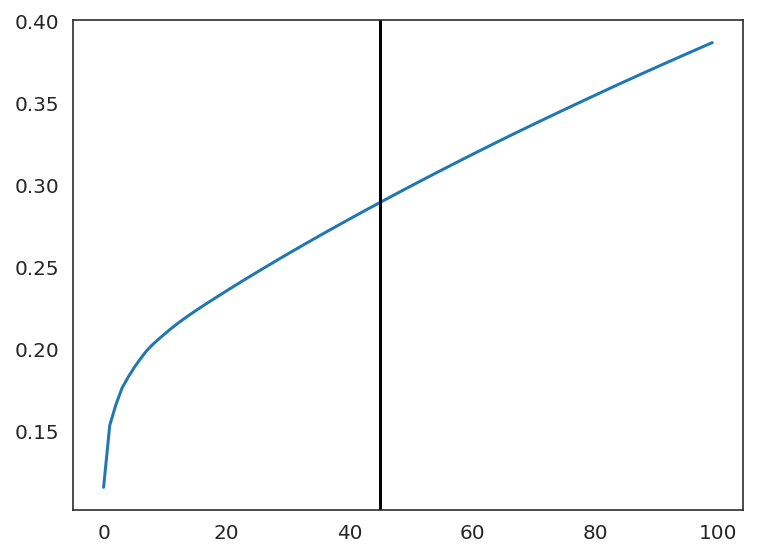

In [60]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [63]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :2671


In [64]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :66


In [65]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.

Celloracle has some custom-classes: Links, Oracle and TFinfo.
You can save such an object using "to_hdf5".

Pleasae use "load_hdf5" function to load the file.


In [66]:
# Save oracle object.
oracle.to_hdf5("Paul_15_data.celloracle.oracle")

In [19]:
# Load file.
#oracle = co.load_hdf5("Paul_15_data.celloracle.oracle")

# 5. GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

You can calculate  GRNs with the "get_links" function, and the function returns GRNs as a Links object.
The Links object stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

The GRN will be calculated for each cluster/sub-group.
In the example below, we construct GRN for each unit of the "louvain_annot" clustering.

The GRNs can be calculated at any arbitrary unit as long as the clustering information is stored in anndata.

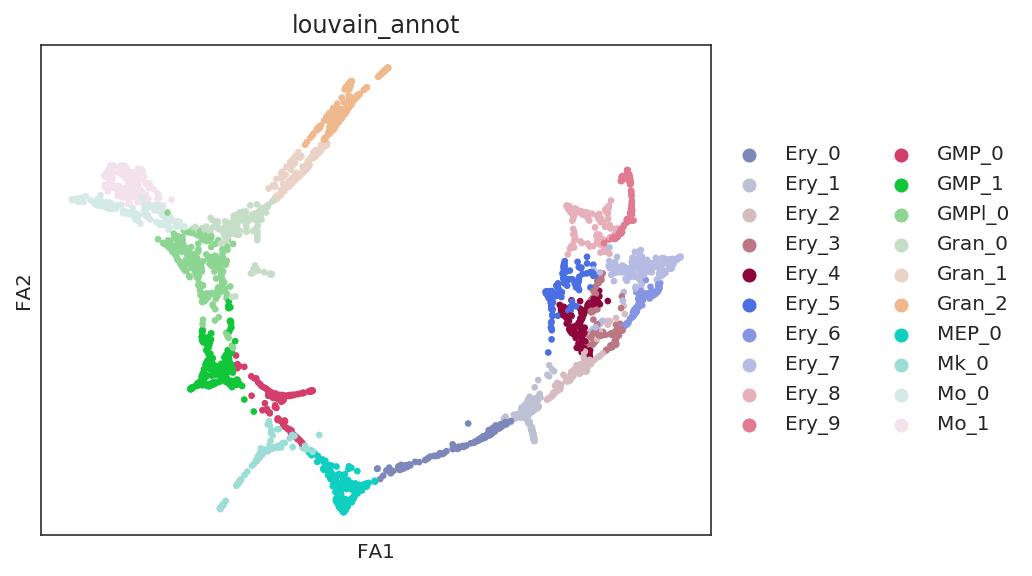

In [67]:
# check data
sc.pl.draw_graph(oracle.adata, color="louvain_annot")

## 5.1. Get GRNs

In [ ]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take long time.
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=10, test_mode=False)




## 5.2. (Optional) Export GRNs

Although celloracle has many functions for network analysis, you can analyze GRNs by hand if you choose.
The raw GRN data is stored in the attribute of "links_dict".

For example, you can get the GRN for the "Ery_0" cluster with the following commands.

In [72]:
links.links_dict.keys()

dict_keys(['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMPl_0', 'Gran_0', 'Gran_1', 'Gran_2', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1'])

In [73]:
links.links_dict["Ery_0"]

,source,target,coef_mean,coef_abs,p,-logp
0,Stat3,0610007L01Rik,-0.010275,0.010275,3.476931e-07,6.458804
1,Gata1,0610007L01Rik,-0.000380,0.000380,7.598357e-01,0.119280
2,Zbtb1,0610007L01Rik,0.004452,0.004452,1.018526e-03,2.992028
3,Rara,0610007L01Rik,-0.000669,0.000669,7.065405e-01,0.150863
4,Myc,0610007L01Rik,-0.010705,0.010705,1.696471e-05,4.770454
...,...,...,...,...,...,...
74420,Smarcc2,Zyx,-0.003475,0.003475,2.754236e-02,1.559999
74421,Nfe2,Zyx,0.031430,0.031430,1.461503e-11,10.835200
74422,Zbtb4,Zyx,0.001684,0.001684,1.915555e-01,0.717705
74423,Smarcc1,Zyx,0.011356,0.011356,1.843519e-04,3.734352


You can export the file as follows.

In [ ]:
# Set cluster name
cluster = "Ery_0"

# Save as csv
links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")

## 5.3. (Optional) Change order

The links object has a color information in an attribute, "palette".
This information is used for the visualization

The sample will be visualized in that order. 
Here we can change the order.

In [75]:
# Show the contents of pallete
links.palette

,palette
MEP_0,#0FCFC0
Mk_0,#9CDED6
Ery_0,#7D87B9
Ery_1,#BEC1D4
Ery_2,#D6BCC0
Ery_3,#BB7784
Ery_4,#8E063B
Ery_5,#4A6FE3
Ery_6,#8595E1
Ery_7,#B5BBE3


In [76]:
# Change the order of pallete
order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5',
         'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','GMP_0', 'GMP_1',
         'GMPl_0', 'Mo_0', 'Mo_1', 'Gran_0', 'Gran_1', 'Gran_2']
links.palette = links.palette.loc[order]
links.palette

,palette
MEP_0,#0FCFC0
Mk_0,#9CDED6
Ery_0,#7D87B9
Ery_1,#BEC1D4
Ery_2,#D6BCC0
Ery_3,#BB7784
Ery_4,#8E063B
Ery_5,#4A6FE3
Ery_6,#8595E1
Ery_7,#B5BBE3


# 6. Network preprocessing

## 6.1. Filter network edges 
Celloracle utilizes bagging ridge or Bayesian ridge regression to infer gene regulatory networks. 
These methods provide a network edge strength as a distribution rather than a point value. 
We can use the distribution to know the certainness of the connection.

We filter the network edges as follows.

 (1) Remove uncertain network edges based on the p-value.
 
 (2) Remove weak network edge. In this tutorial, we pick up the top 2000 edges in terms of network strength.


The raw network data is stored as an attribute, "links_dict," while filtered network data is stored in "filtered_links." 
Thus the filtering function keeps raw network information rather than overwriting the data. You can come back to the filtering process to filter the data with different parameters if you want.

In [78]:
links.filter_links(p=0.001, weight="coef_abs", thread_number=2000)

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.
Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [9]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Ery_0


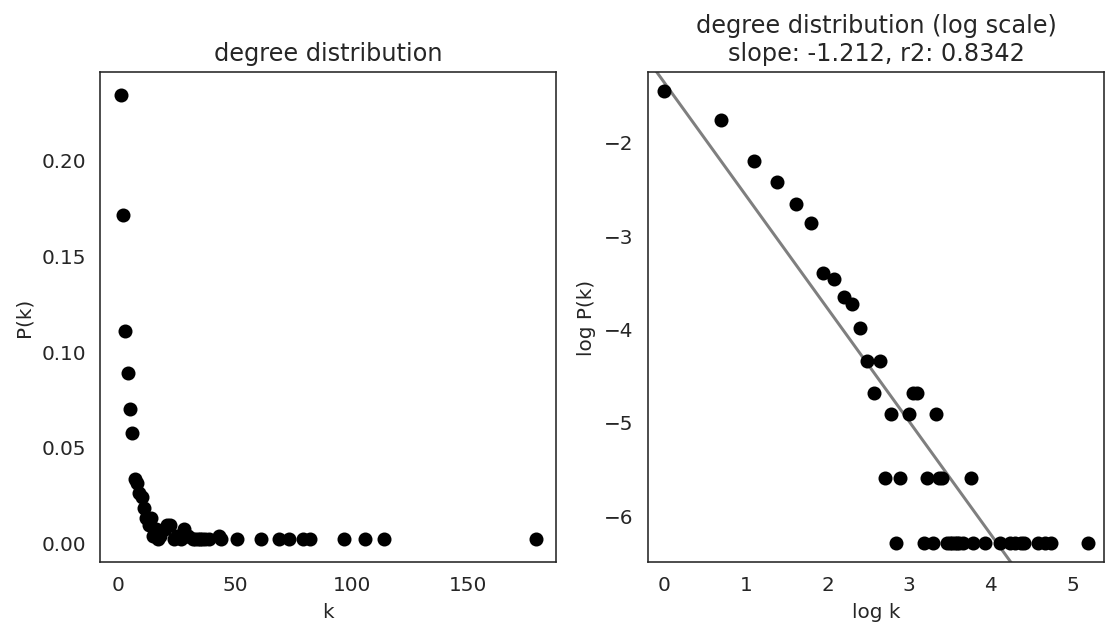

Ery_1


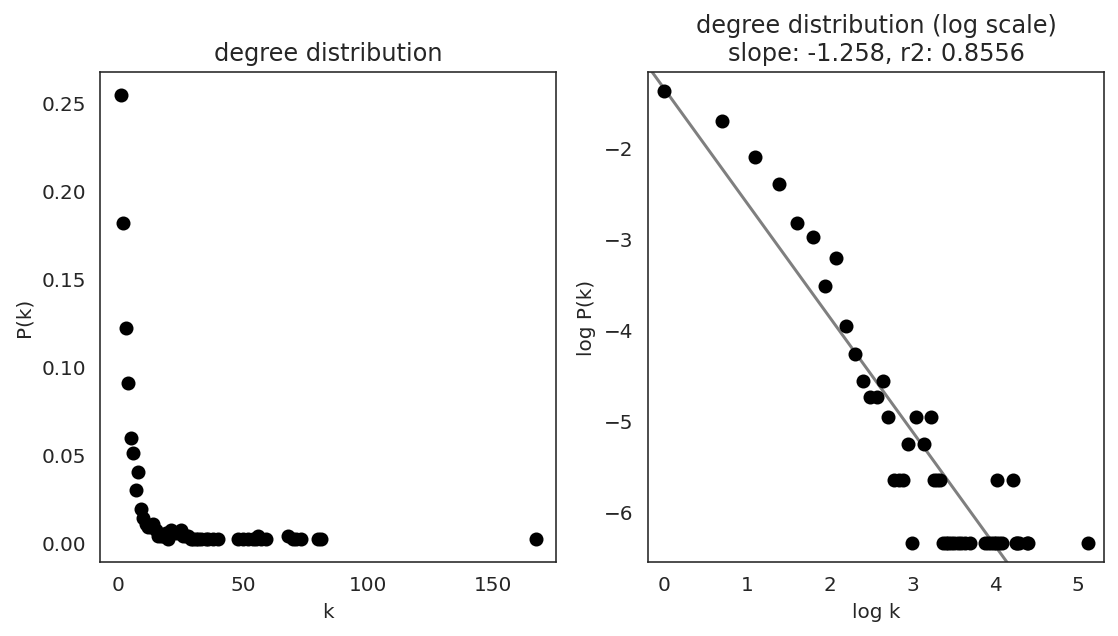

Ery_2


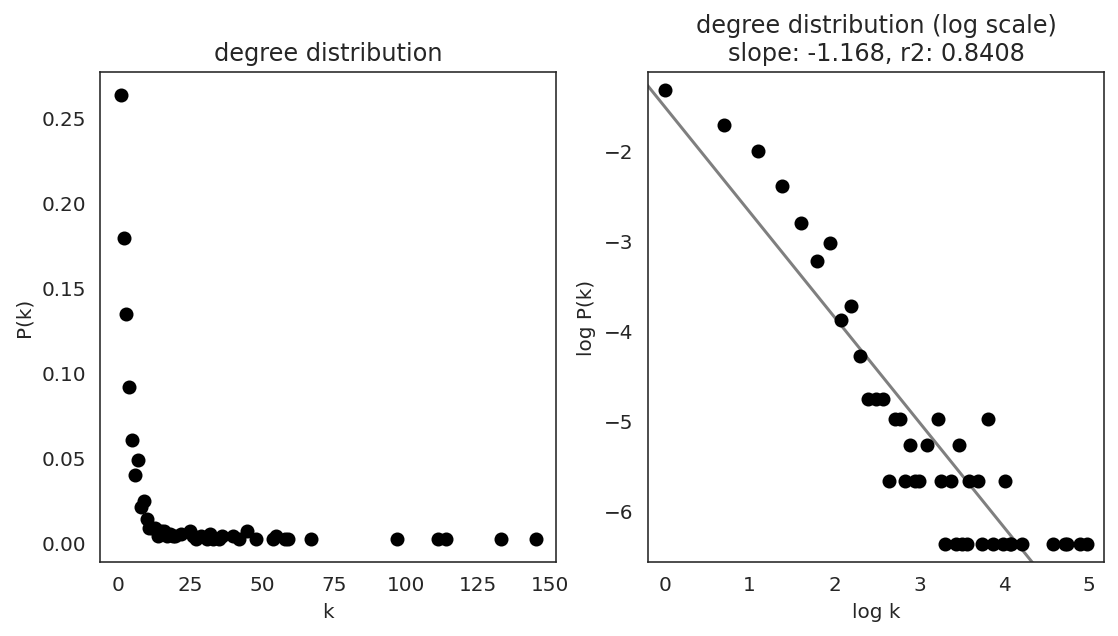

Ery_3


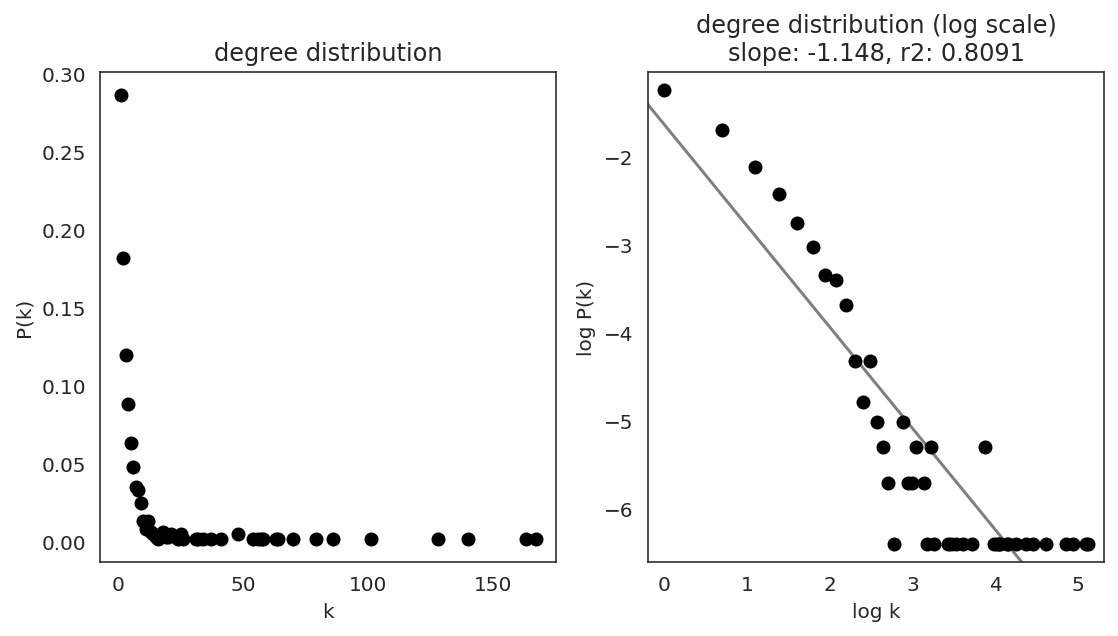

Ery_4


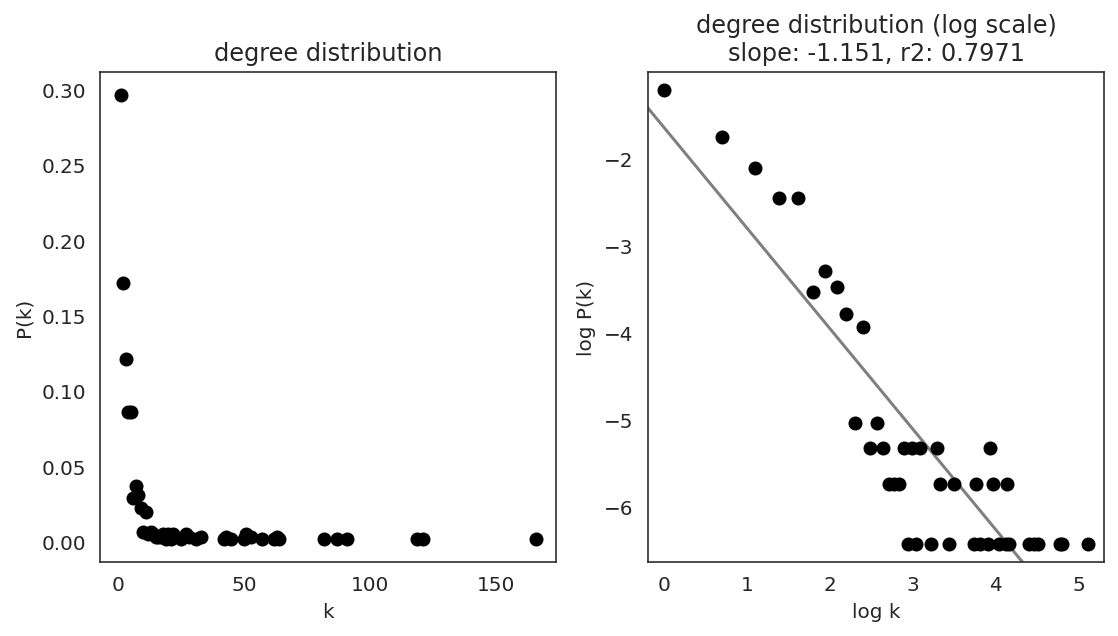

Ery_5


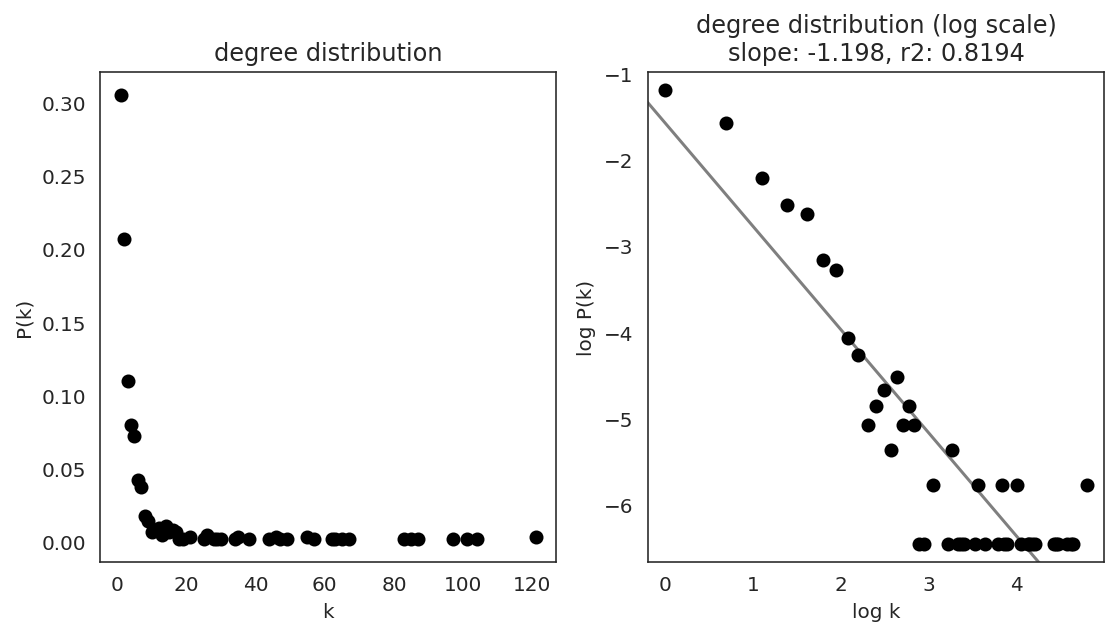

Ery_6


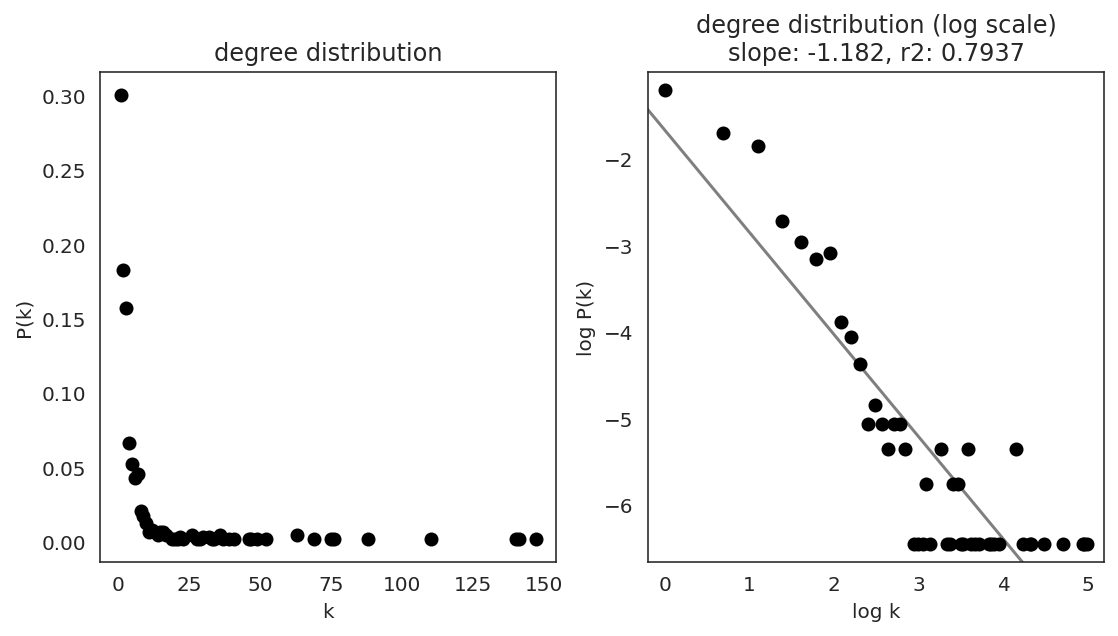

Ery_7


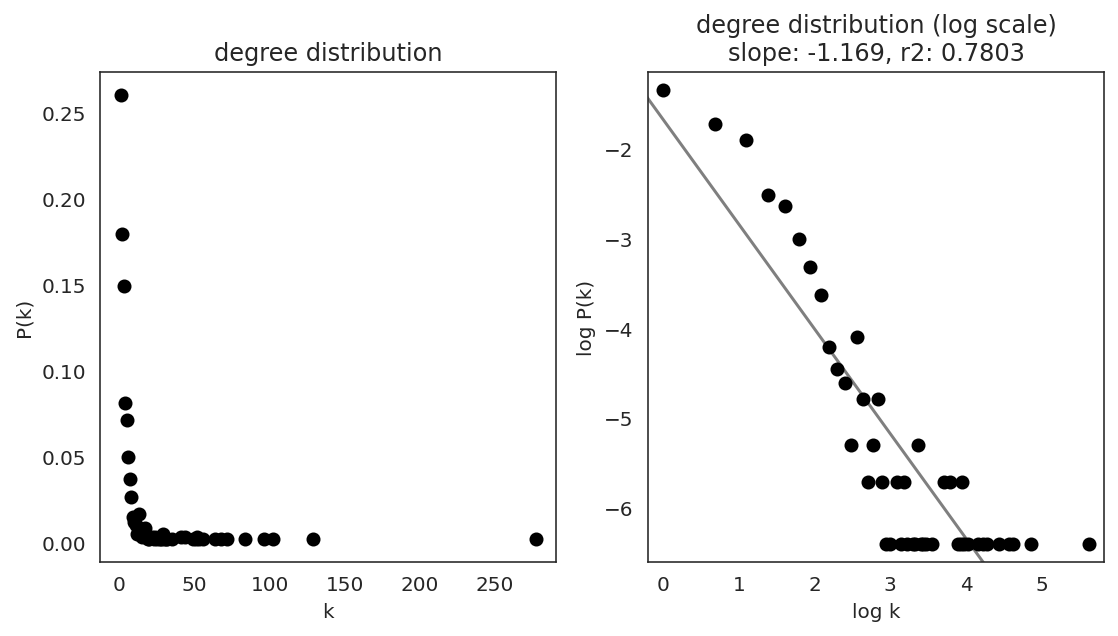

Ery_8


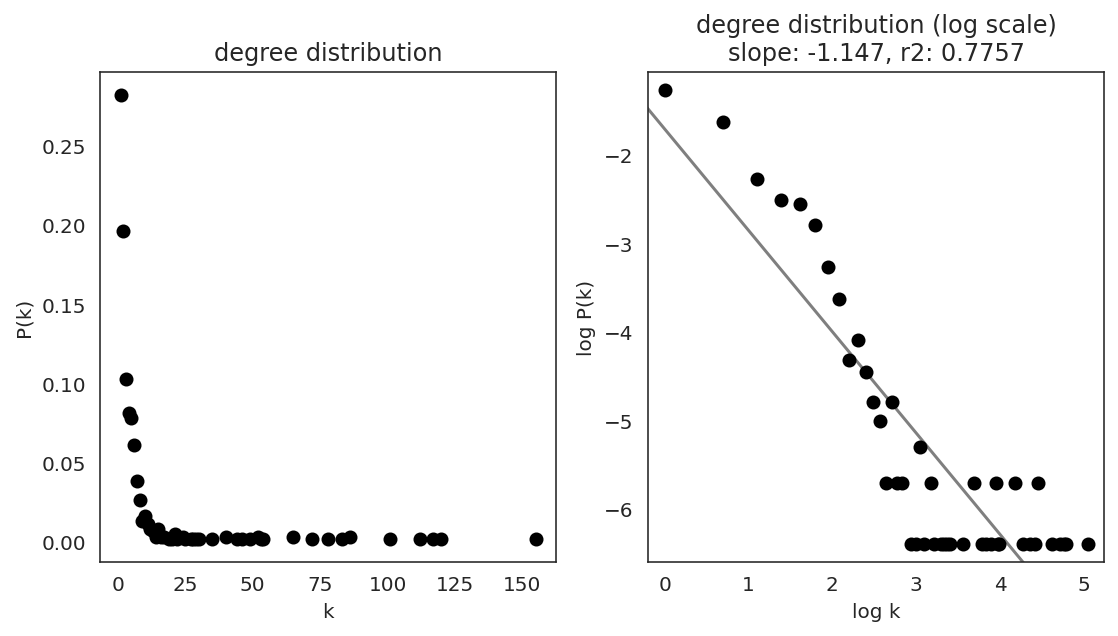

Ery_9


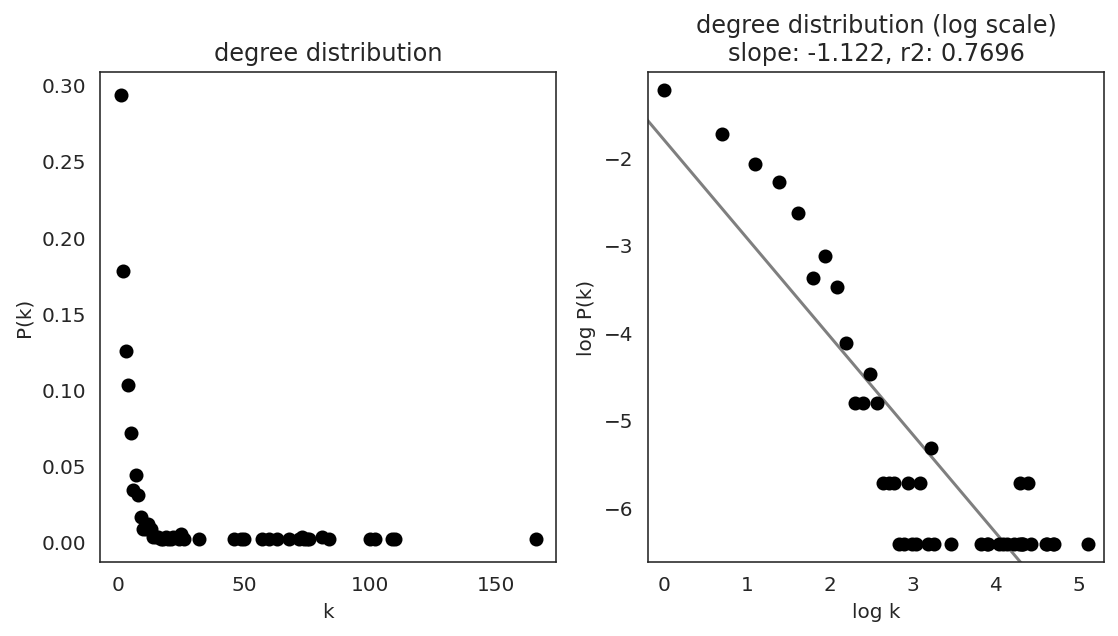

GMP_0


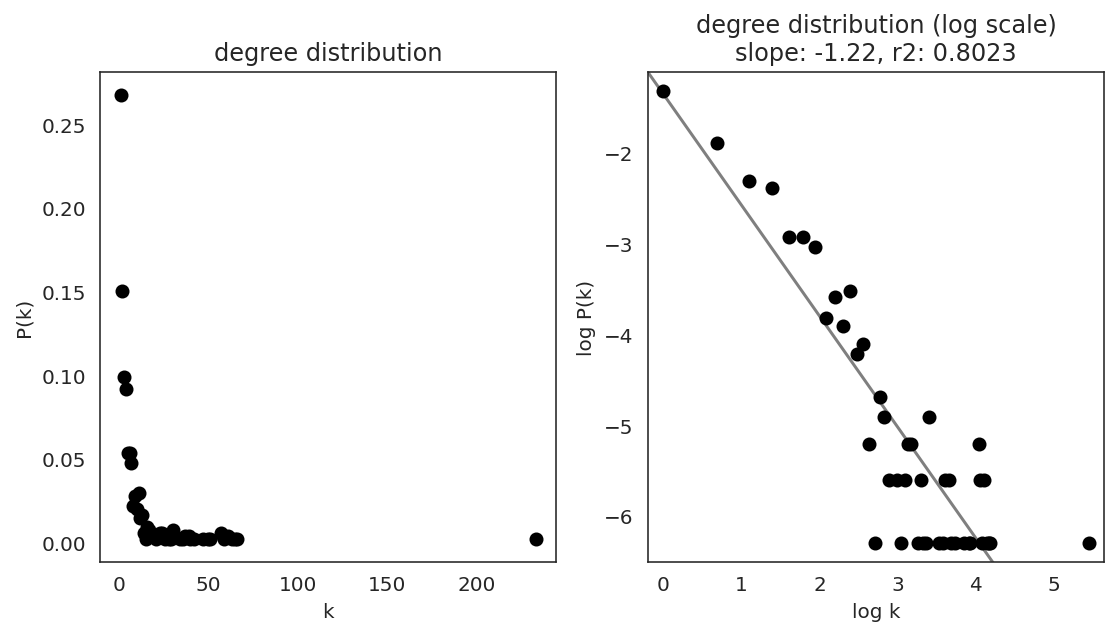

GMP_1


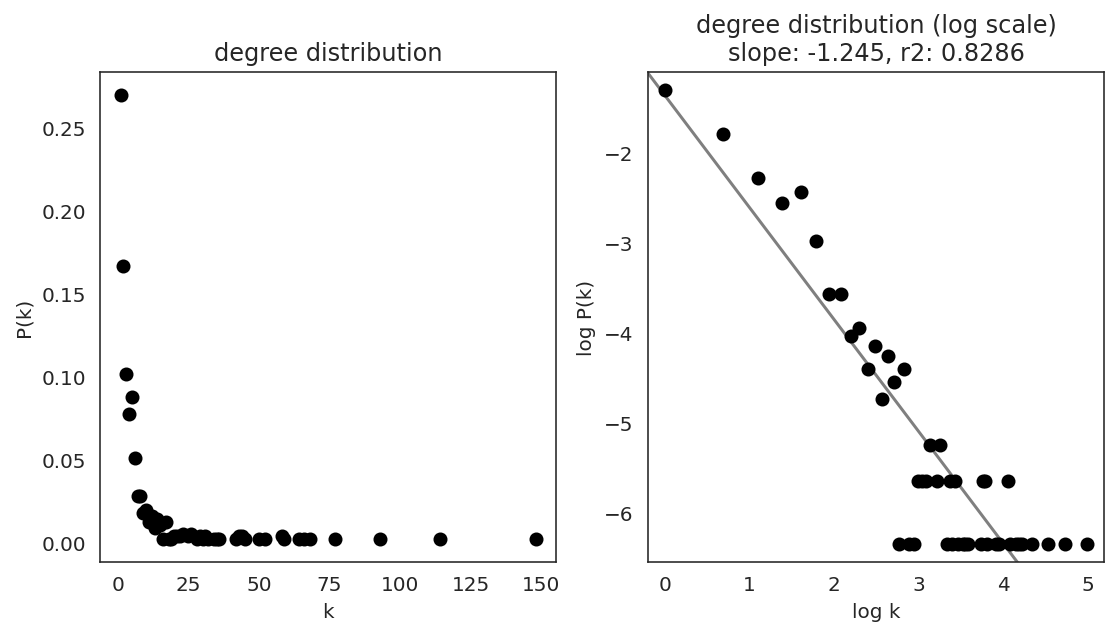

GMPl_0


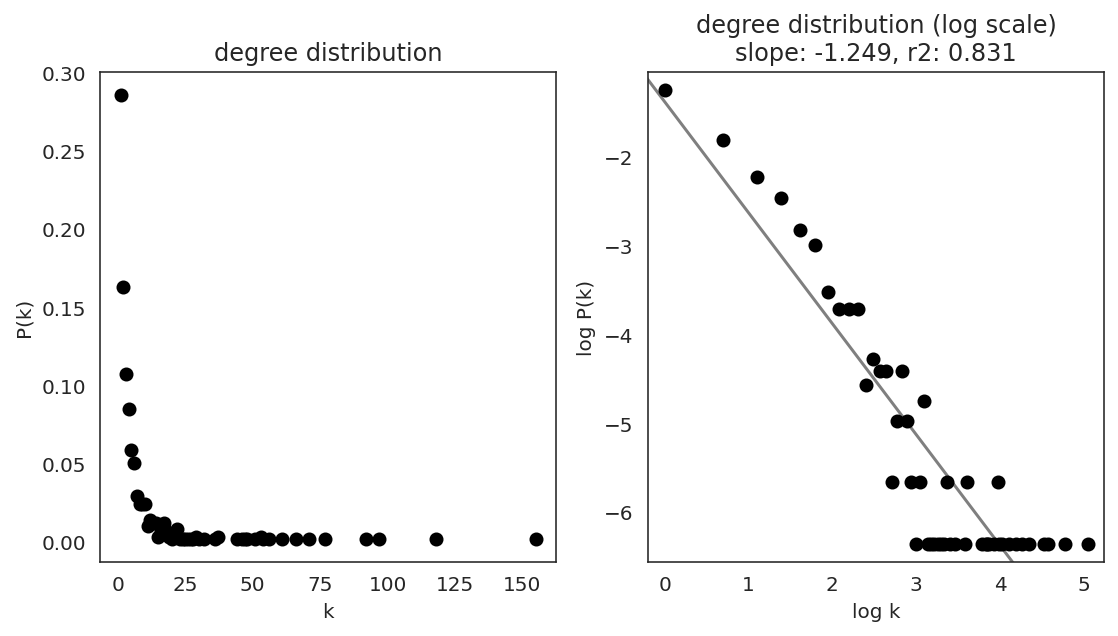

Gran_0


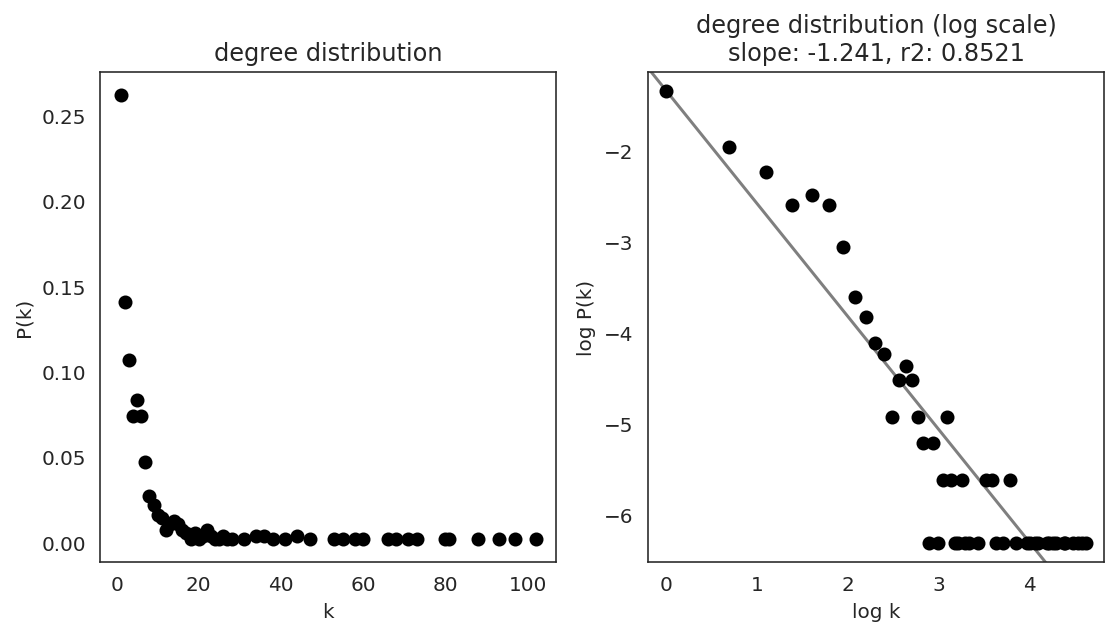

Gran_1


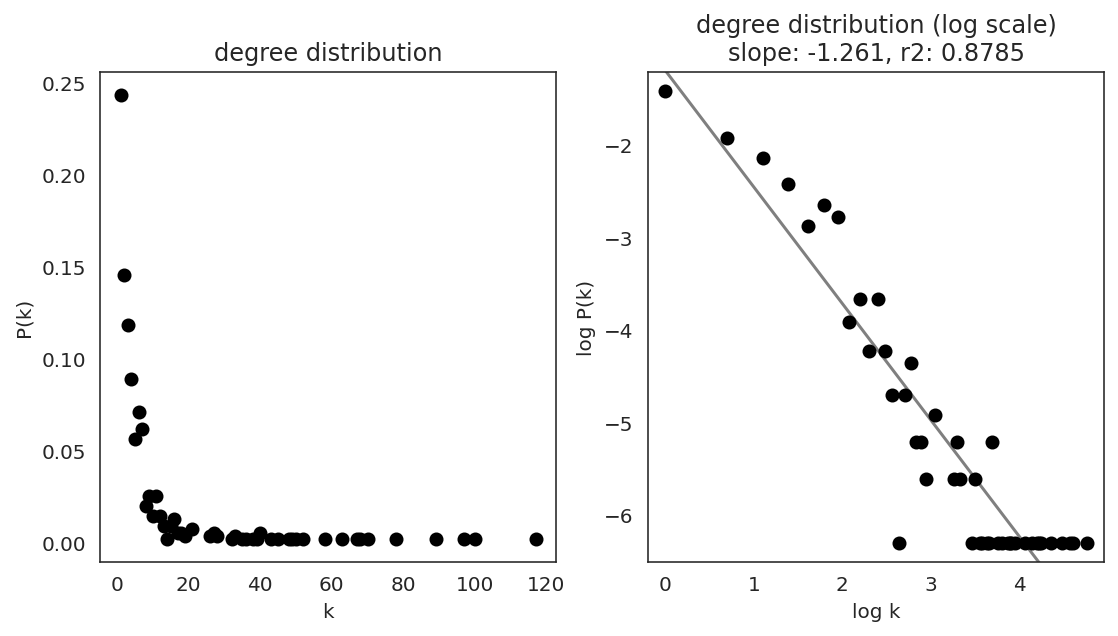

Gran_2


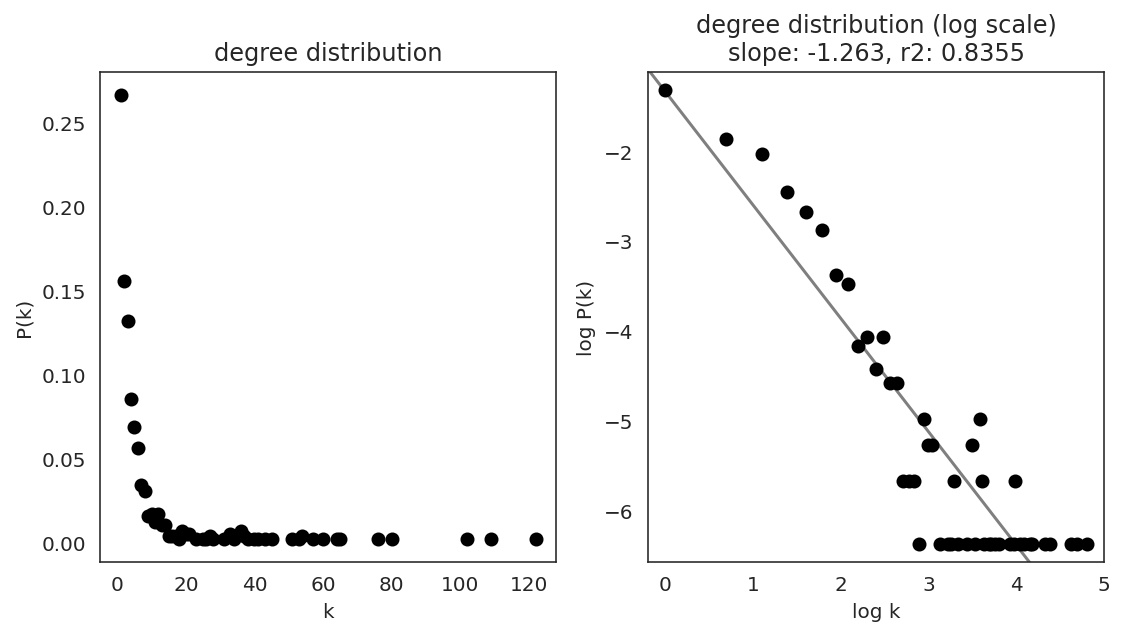

MEP_0


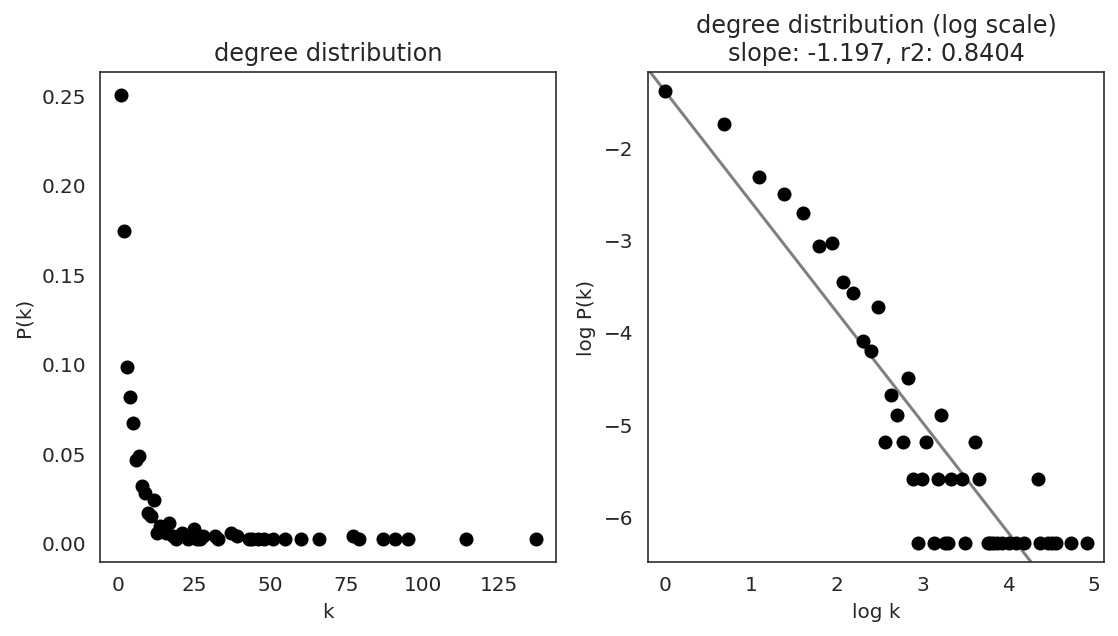

Mk_0


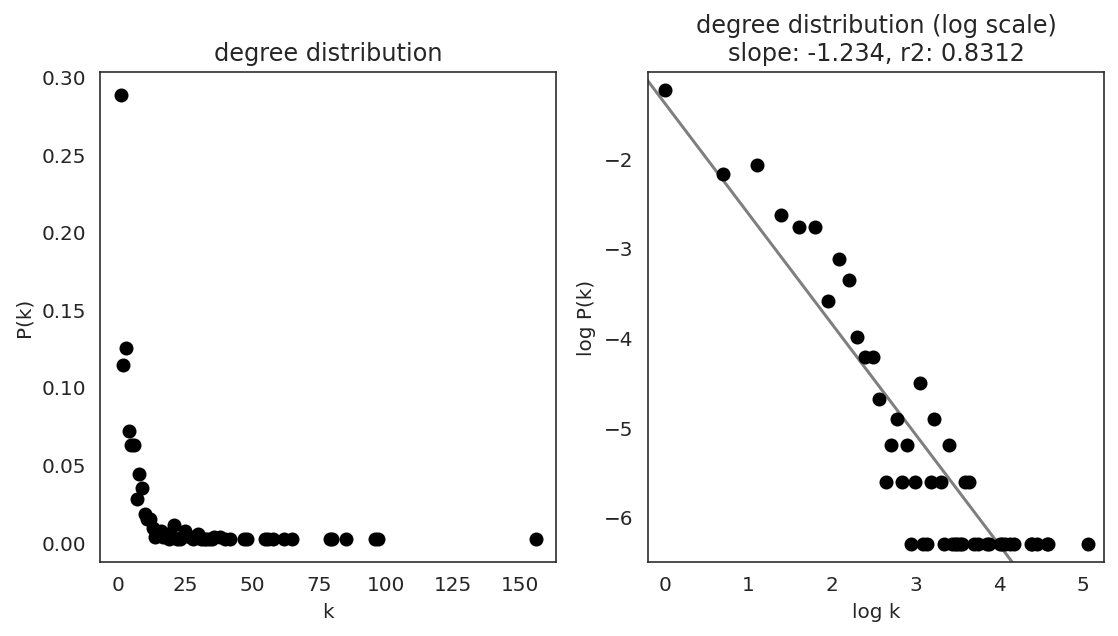

Mo_0


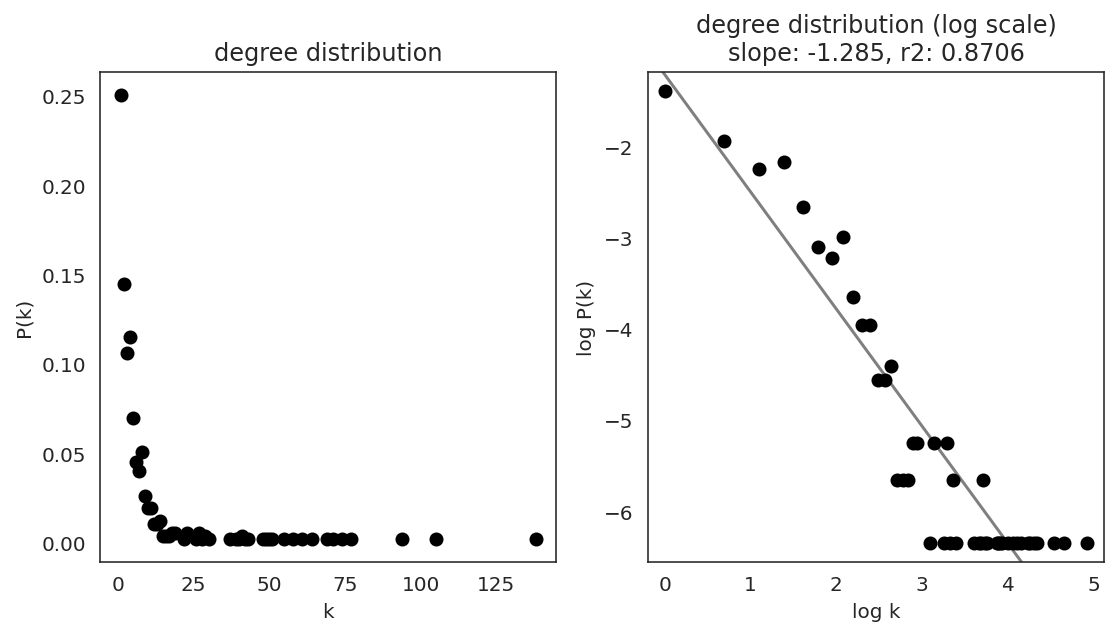

Mo_1


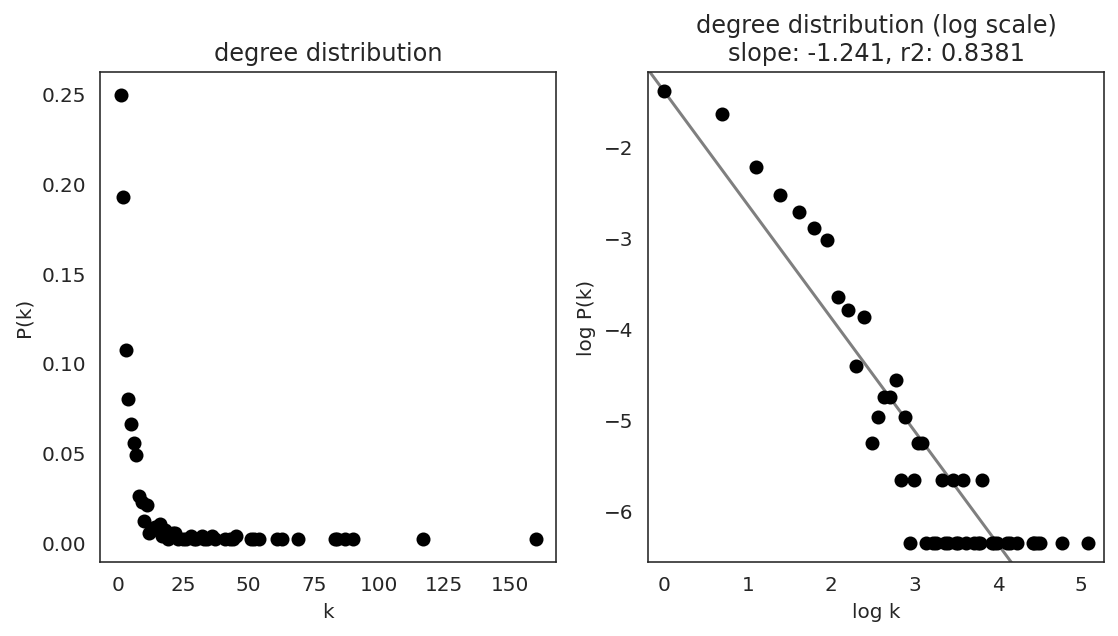

In [10]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [28]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 5.3. Calculate netowrk score

Next, we calculate several network score using some R libraries.
Please make sure that R libraries are installed in your PC before running the command below.


In [25]:
# Calculate network scores. It takes several minutes.
links.get_score()

processing... batch 1/3
Ery_0: finished.
Ery_1: finished.
Ery_2: finished.
Ery_3: finished.
Ery_4: finished.
Ery_5: finished.
Ery_6: finished.
Ery_7: finished.
processing... batch 2/3
Ery_8: finished.
Ery_9: finished.
GMP_0: finished.
GMP_1: finished.
GMPl_0: finished.
Gran_0: finished.
Gran_1: finished.
Gran_2: finished.
processing... batch 3/3
MEP_0: finished.
Mk_0: finished.
Mo_0: finished.
Mo_1: finished.


The score is stored as a attribute called "merged_score", and the score will also be saved in a folder in your computer.

In [82]:
links.merged_score.head()

,degree_all,degree_in,degree_out,clustering_coefficient,clustering_coefficient_weighted,degree_centrality_all,degree_centrality_in,degree_centrality_out,betweenness_centrality,closeness_centrality,eigenvector_centrality,page_rank,assortative_coefficient,average_path_length,community_random_walk,module,connectivity,participation,role,cluster
Stat3,82,0,82,0.021981,0.022055,0.151292,0.000000,0.151292,0,0.000012,0.487978,0.001633,-0.161693,2.621324,1,0,3.573858,0.647531,Connector Hub,Ery_0
Mycn,30,0,30,0.011494,0.009986,0.055351,0.000000,0.055351,0,0.000010,0.245650,0.001633,-0.161693,2.621324,1,2,1.767680,0.595556,Peripheral,Ery_0
E2f4,181,2,179,0.009822,0.011874,0.333948,0.003690,0.330258,3158,0.000010,1.000000,0.001724,-0.161693,2.621324,1,0,8.575037,0.632252,Connector Hub,Ery_0
Zbtb1,22,0,22,0.000000,0.000000,0.040590,0.000000,0.040590,0,0.000004,0.113727,0.001633,-0.161693,2.621324,18,2,1.317952,0.533058,Peripheral,Ery_0
Ybx1,69,9,60,0.028133,0.027709,0.127306,0.016605,0.110701,1051,0.000004,0.385376,0.002133,-0.161693,2.621324,2,3,5.306800,0.687251,Connector Hub,Ery_0


## 6.4. Save

Save processed GRN. We use this file in the next notebook; "in silico perturbation with GRNs". 

In [31]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [6]:
# You can load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")


# 7. Network analysis; Network score for each gene
The Links class has many functions to visualize network score.
See the documentation for the details of the functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
We can use the centrality score to identify key regulatory genes because centrality is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [83]:
# Check cluster name
links.cluster

['Ery_0',
 'Ery_1',
 'Ery_2',
 'Ery_3',
 'Ery_4',
 'Ery_5',
 'Ery_6',
 'Ery_7',
 'Ery_8',
 'Ery_9',
 'GMP_0',
 'GMP_1',
 'GMPl_0',
 'Gran_0',
 'Gran_1',
 'Gran_2',
 'MEP_0',
 'Mk_0',
 'Mo_0',
 'Mo_1']

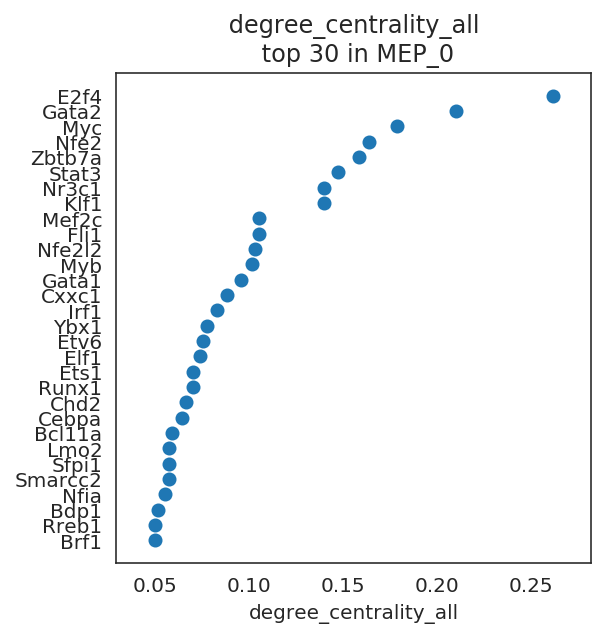

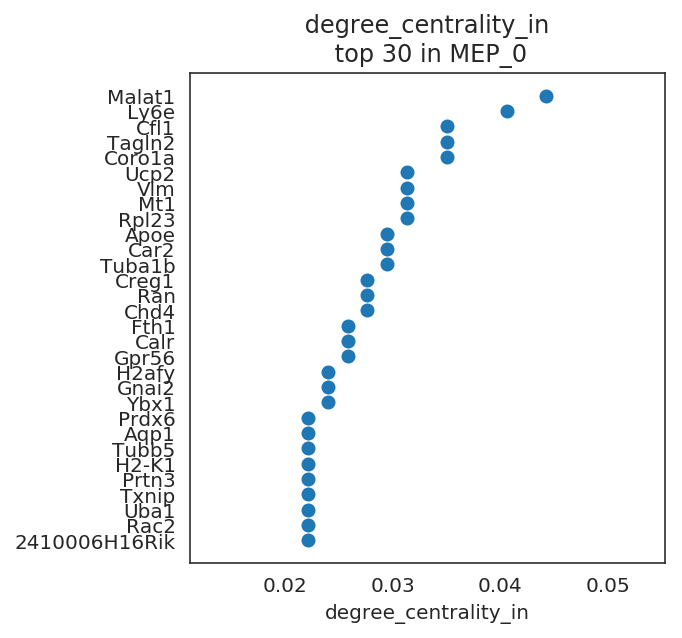

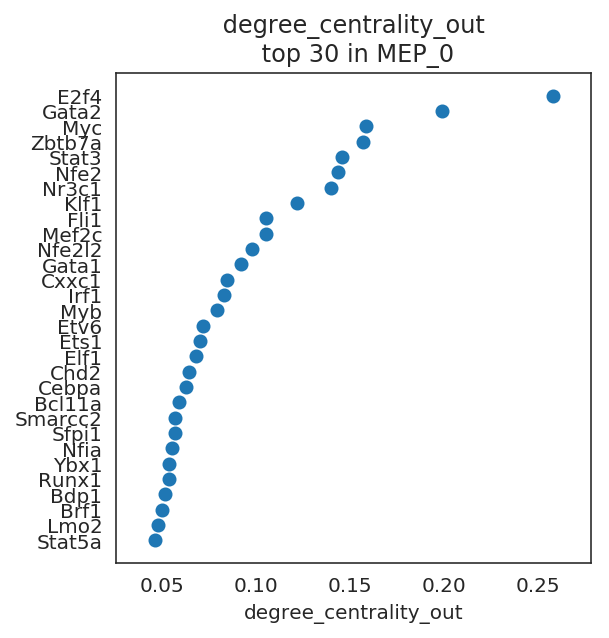

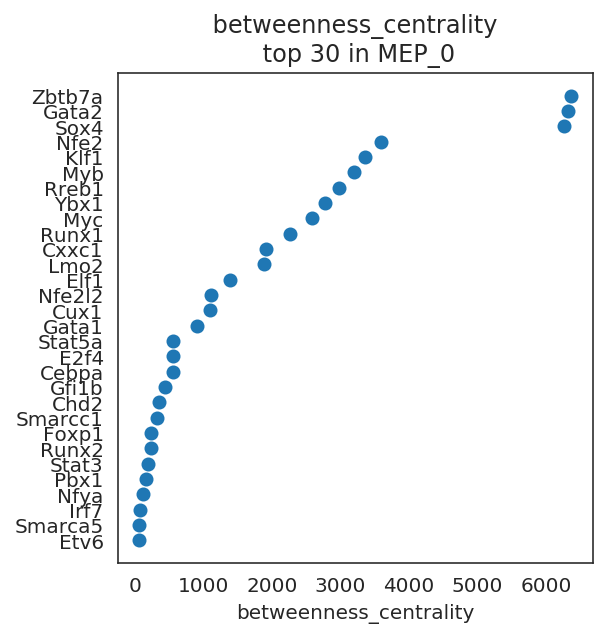

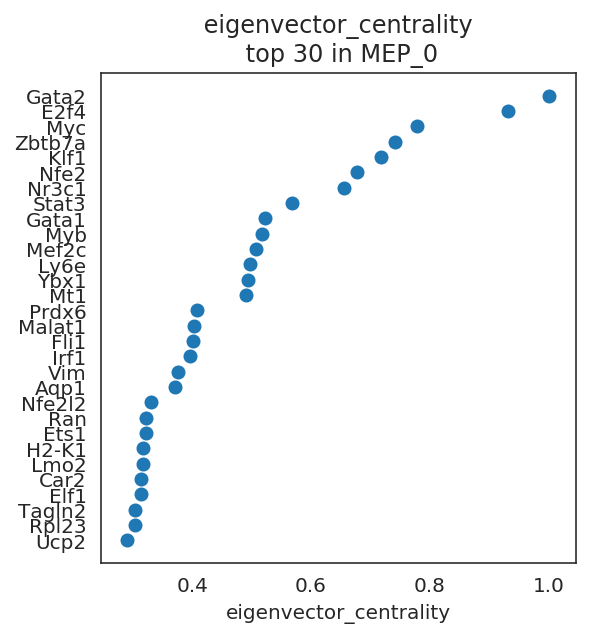

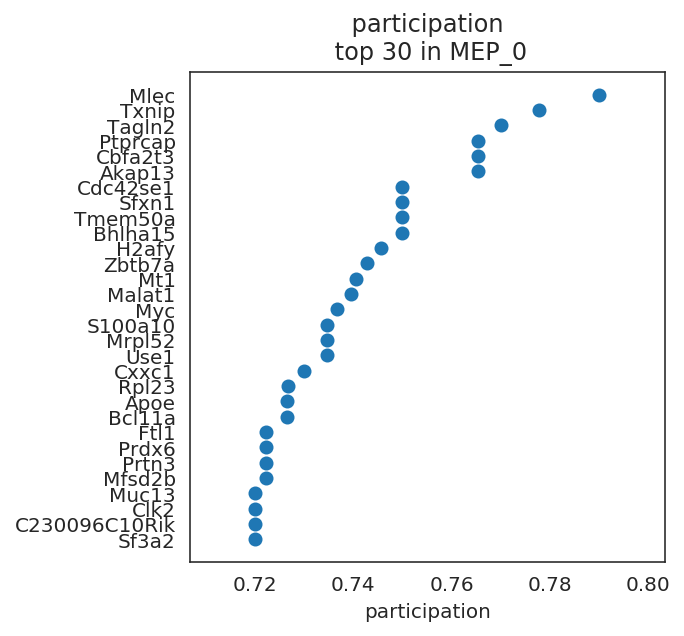

In [53]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="MEP_0", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

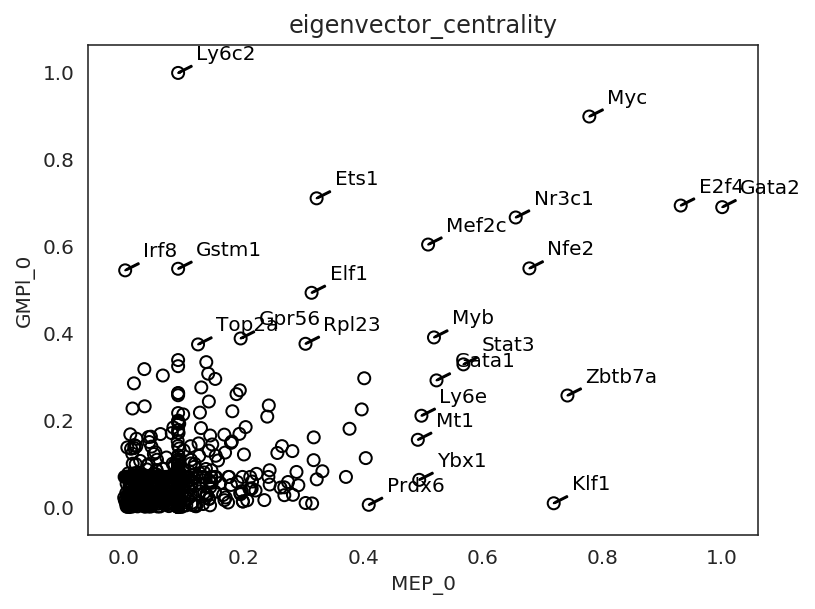

In [54]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

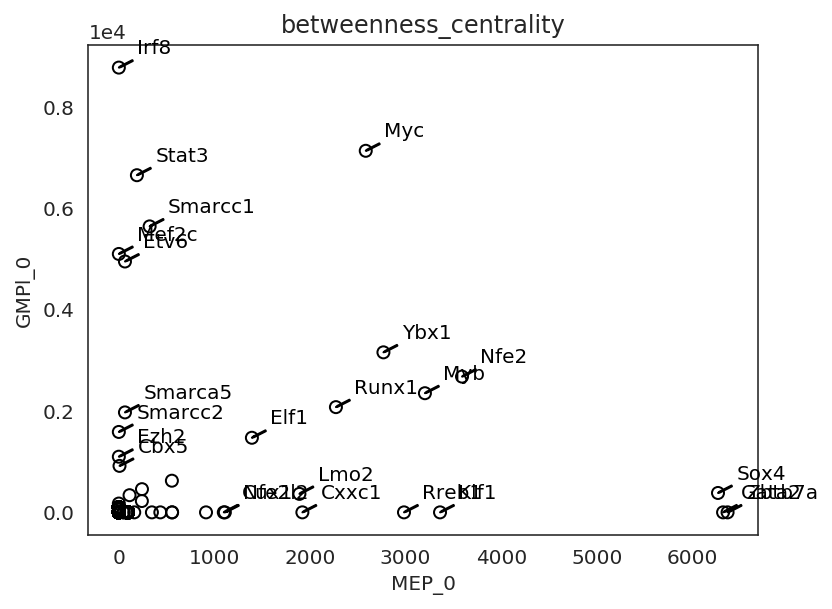

In [55]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

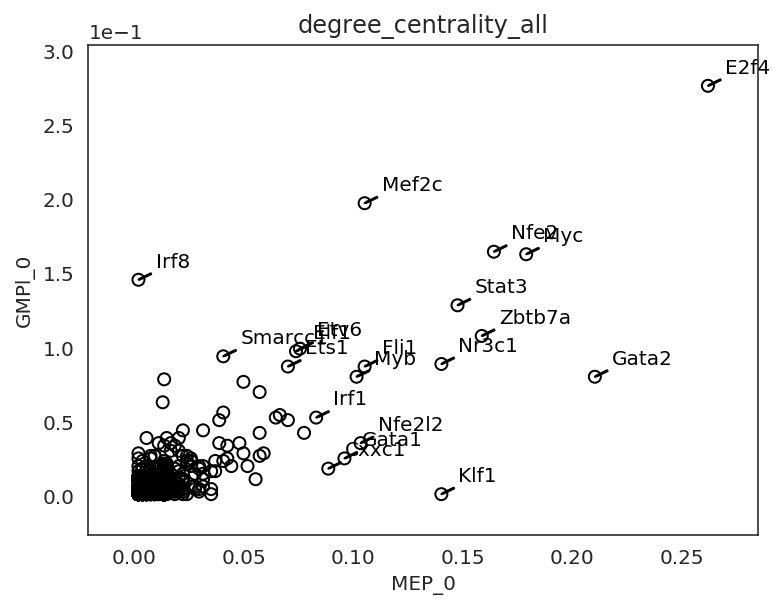

In [56]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

## 7.3. Network score dynamics
In the following session, we focus on how a gene's network score changes during the differentiation.

Using Gata2, we will demonstrate how you can visualize networks scores for a single gene.

Gata2 is known to play an essential role in the early MEP and GMP populations. .

Gata2


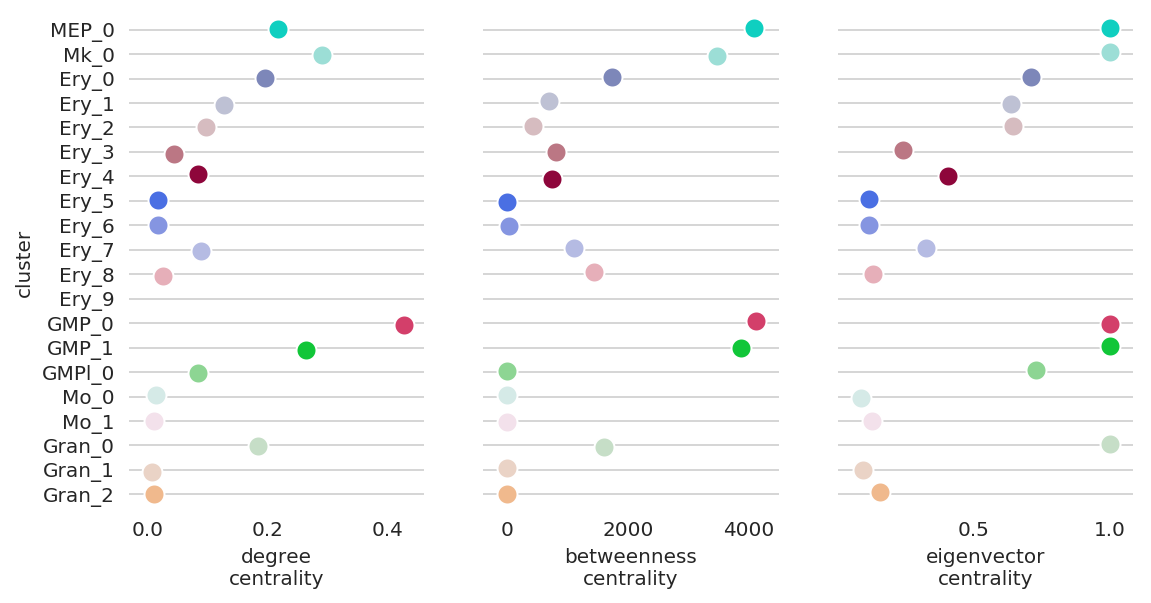

In [30]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="Gata2", save=f"{save_folder}/network_score_per_gene/")

If a gene have no connections in a cluster, it is impossible to calculate network degree scores.
Thus the scores will not be shown.
For example, Cebpa have no connection in the erythloids clusters, and there is no degree scores for Cebpa in these clusters as follows.

Cebpa


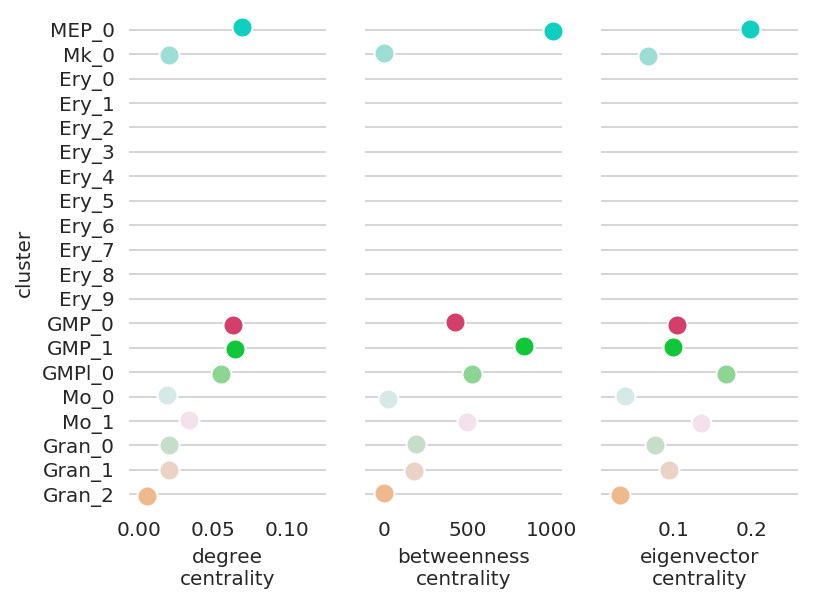

In [38]:
links.plot_score_per_cluster(goi="Cebpa")

You can check filtered network edge as follows.

In [39]:
cluster_name = "Ery_0"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

,source,target,coef_mean,coef_abs,p,-logp
68775,Stat3,Top2a,-0.107635,0.107635,1.976987e-14,13.703996
51655,Mycn,Prdx6,-0.096651,0.096651,8.076169e-11,10.092795
41345,Mycn,Mt1,-0.093897,0.093897,8.228218e-15,14.084694
5136,Ybx1,Anp32b,0.089403,0.089403,4.498303e-14,13.346951
41326,E2f4,Mt1,0.089261,0.089261,7.447929e-10,9.127964


You can confirm that there is no Cebpa connection in Ery_0 cluster.

In [41]:
filtered_links_df[filtered_links_df.source == "Cebpa"]

,source,target,coef_mean,coef_abs,p,-logp


## 7.4. Gene cartography analysis

Gene cartography is a method for gene network analysis.
The method classifies gene into several groups using the network module structure and connections.
It provides us an insight about the role and regulatory mechanism for each gene. 
For more information on gene cartography, please refer to the following paper (https://www.nature.com/articles/nature03288).

The gene cartography will be calculated for the GRN in each cluster.
Thus we can know how the gene cartography change by comparing the the score between clusters.

Ery_0


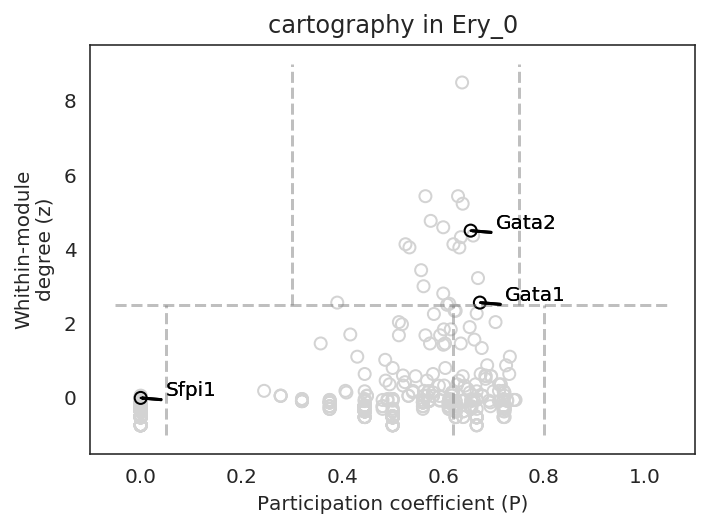

Ery_1


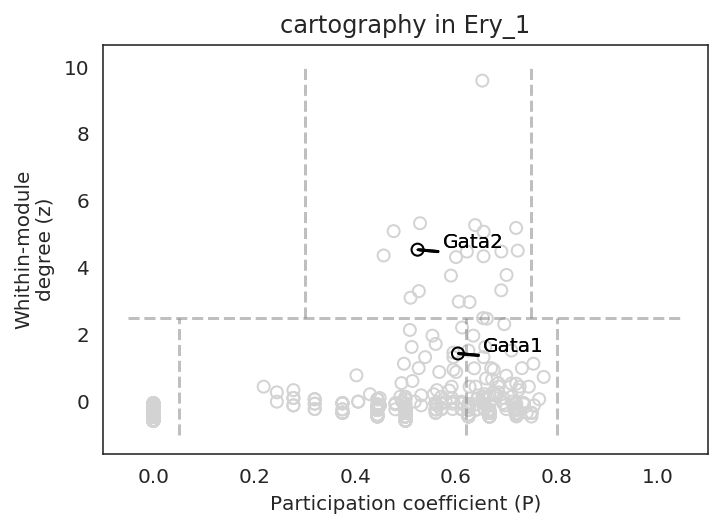

Ery_2


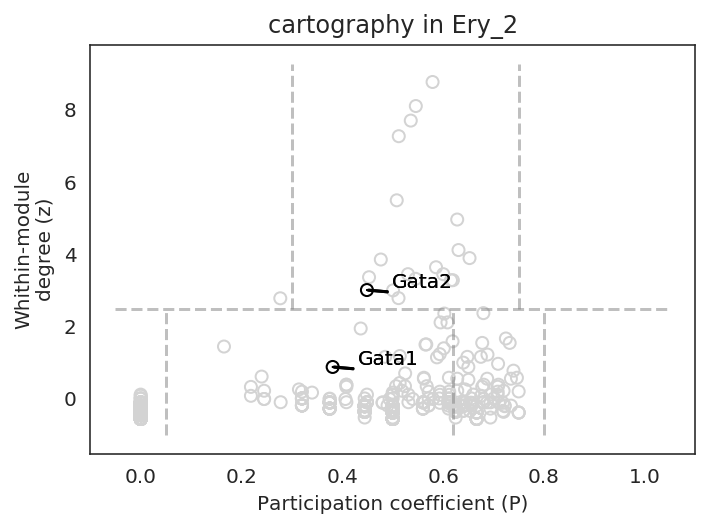

Ery_3


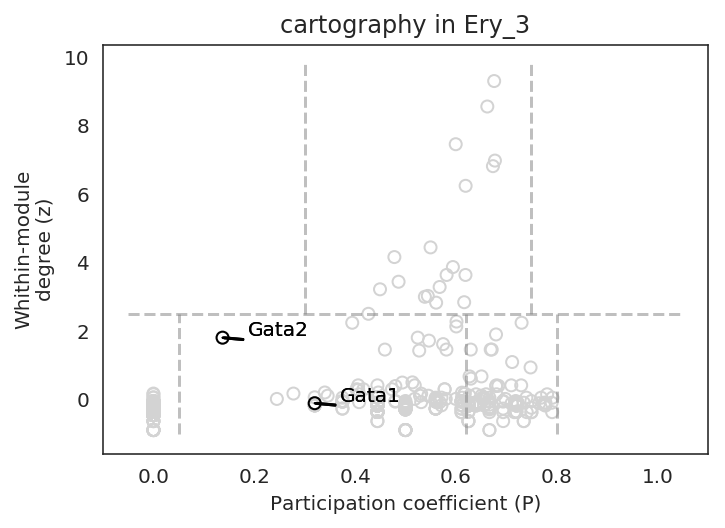

Ery_4


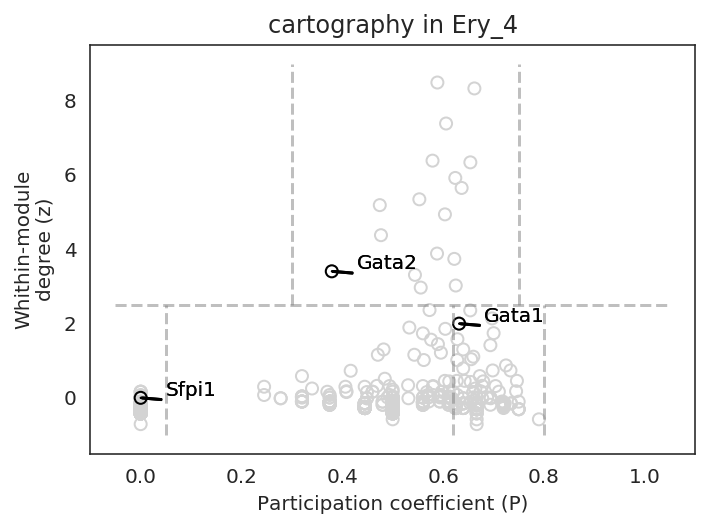

Ery_5


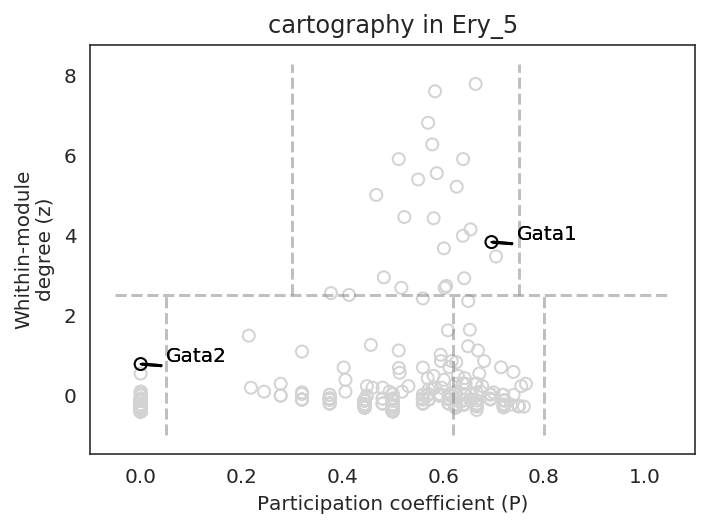

Ery_6


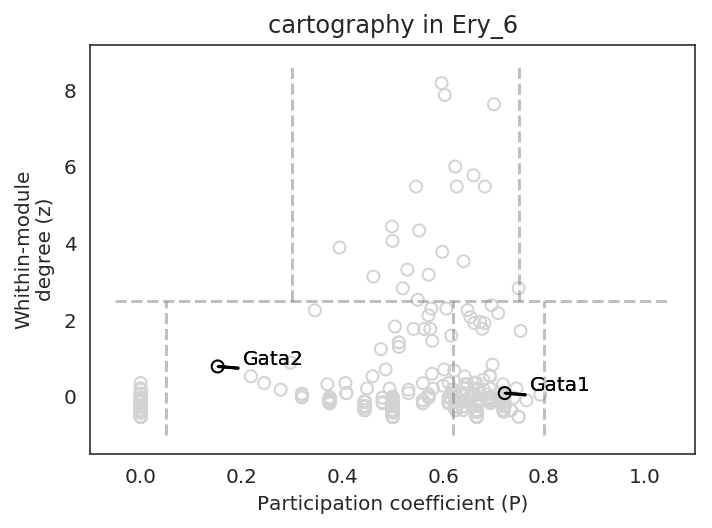

Ery_7


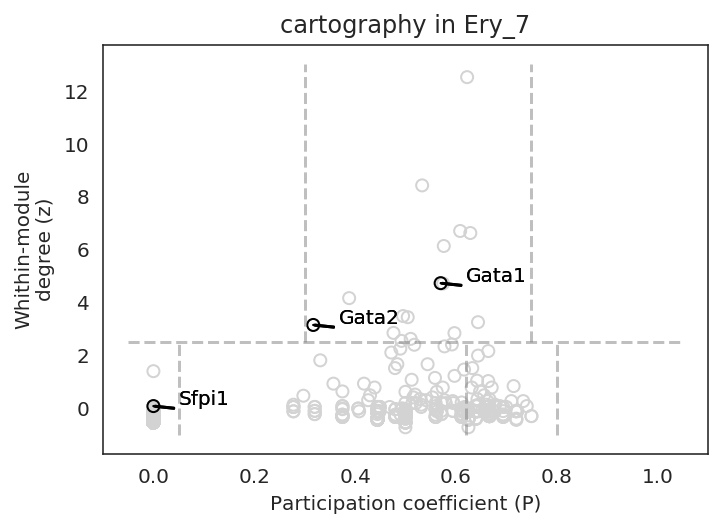

Ery_8


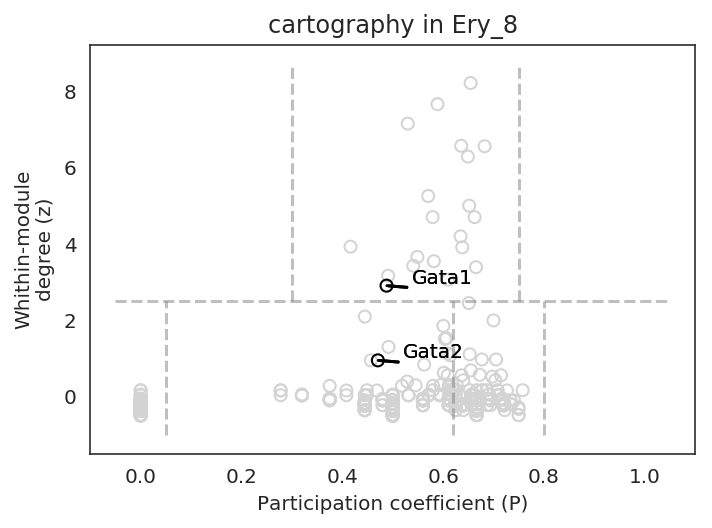

Ery_9


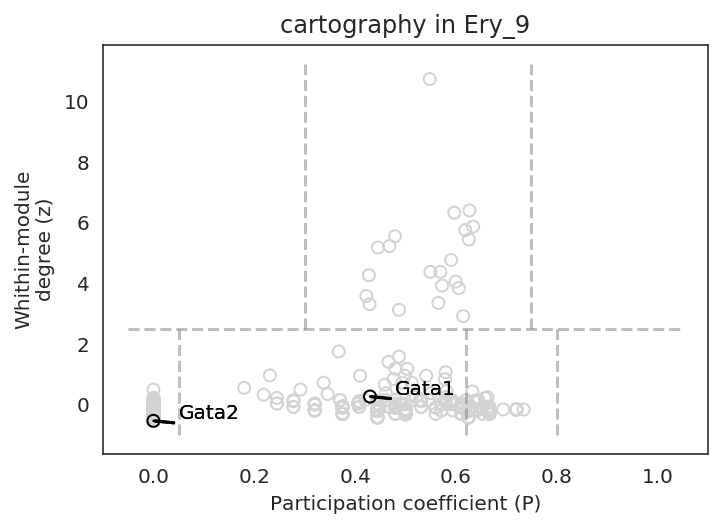

GMP_0


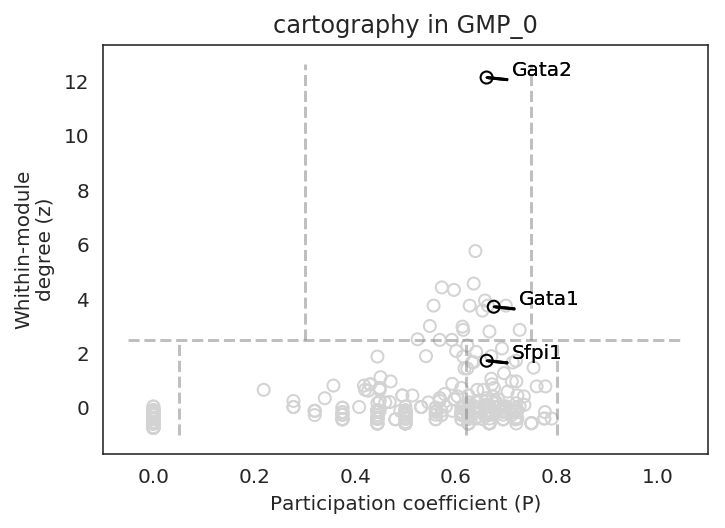

GMP_1


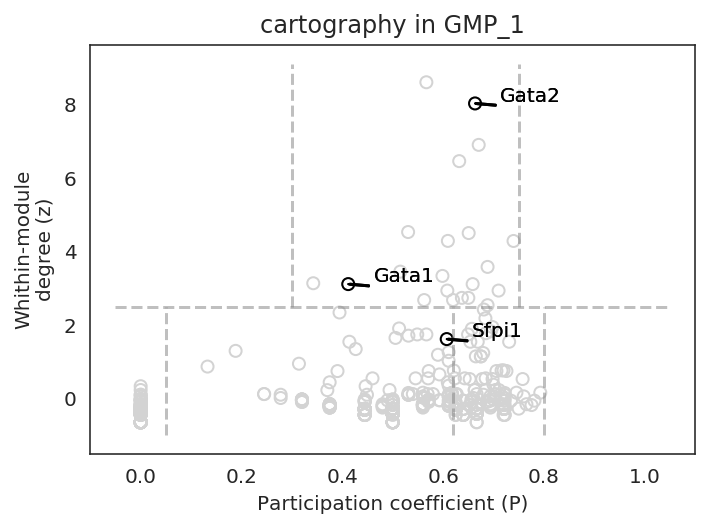

GMPl_0


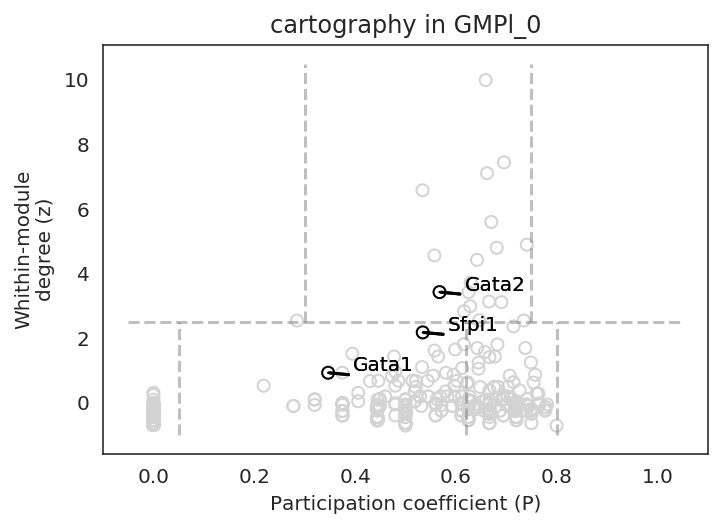

Gran_0


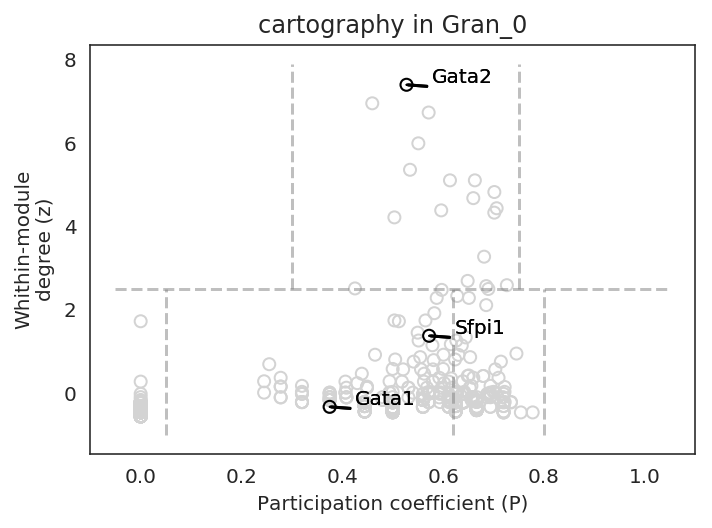

Gran_1


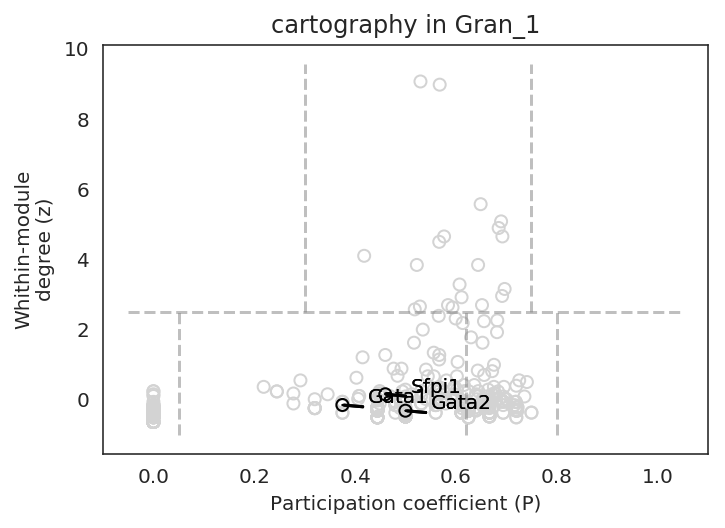

Gran_2


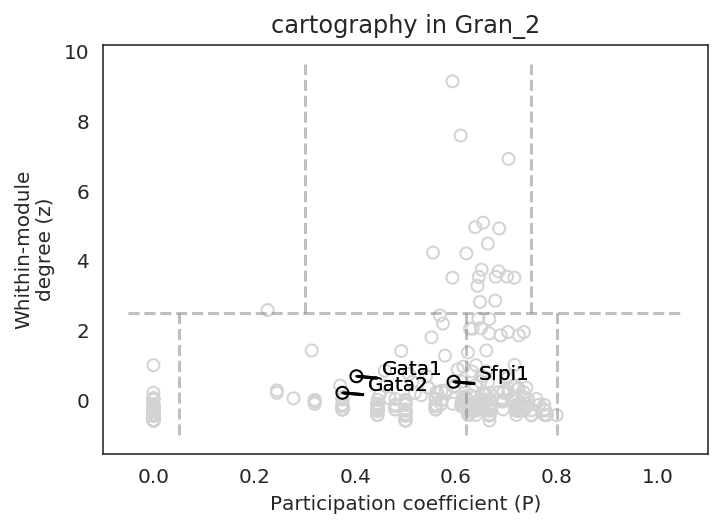

MEP_0


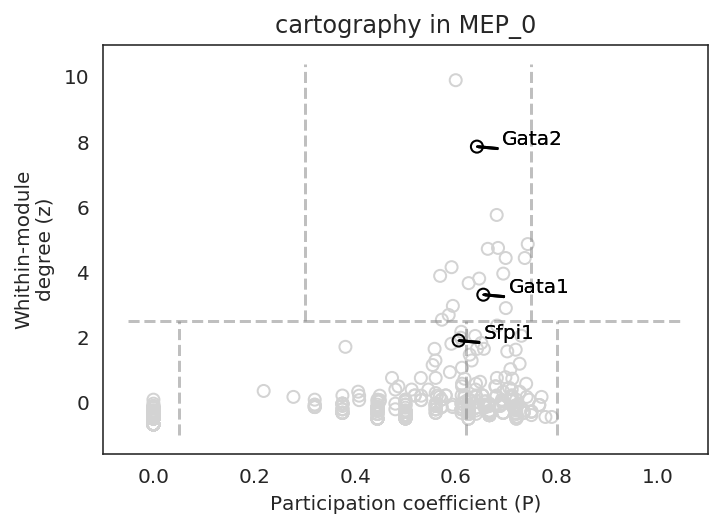

Mk_0


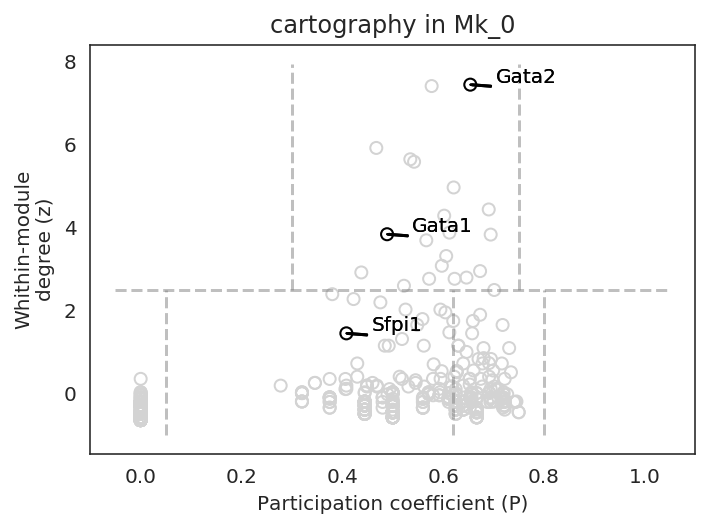

Mo_0


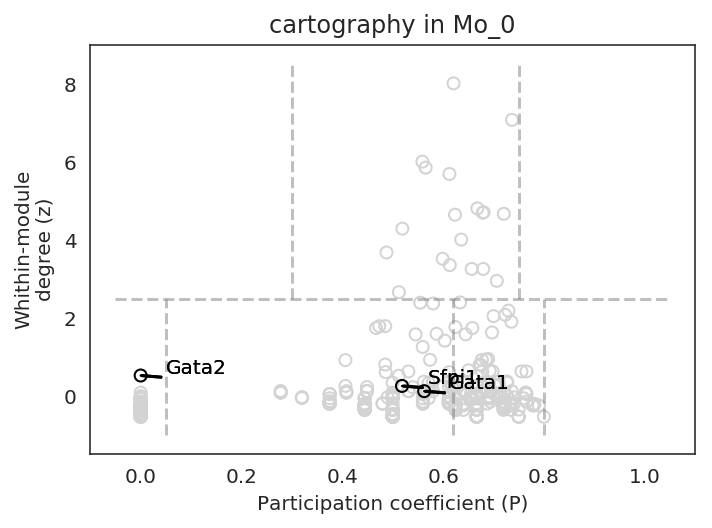

Mo_1


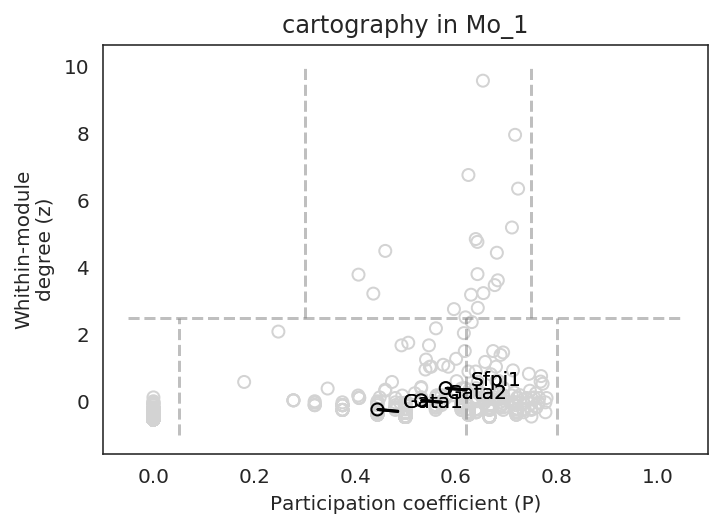

In [58]:
# Plot cartography as a scatter plot
links.plot_cartography_scatter_per_cluster(scatter=True,
                                           kde=False,
                                           gois=["Gata1", "Gata2", "Sfpi1"],
                                           auto_gene_annot=False,
                                           args_dot={"n_levels": 105},
                                           args_line={"c":"gray"}, save=f"{save_folder}/cartography")

Gata2


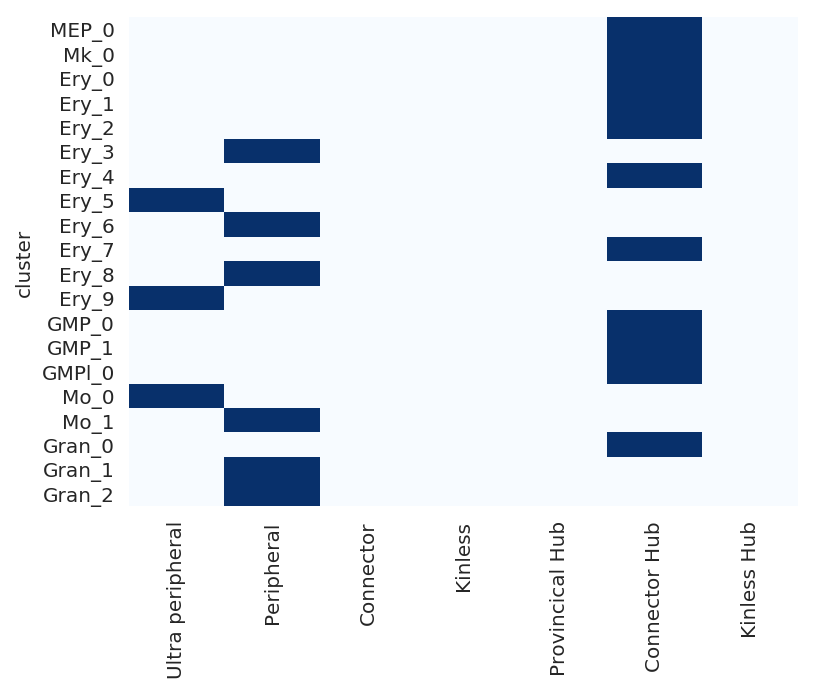

In [66]:
# Plot the summary of cartography analysis
links.plot_cartography_term(goi="Gata2", save=f"{save_folder}/cartography")

# 8. Network analysis; network score distribution

Next, we visualize the distribution of network score to get insight into the global trend of the GRNs.

## 8.1. Distribution of network degree

degree_centrality_all


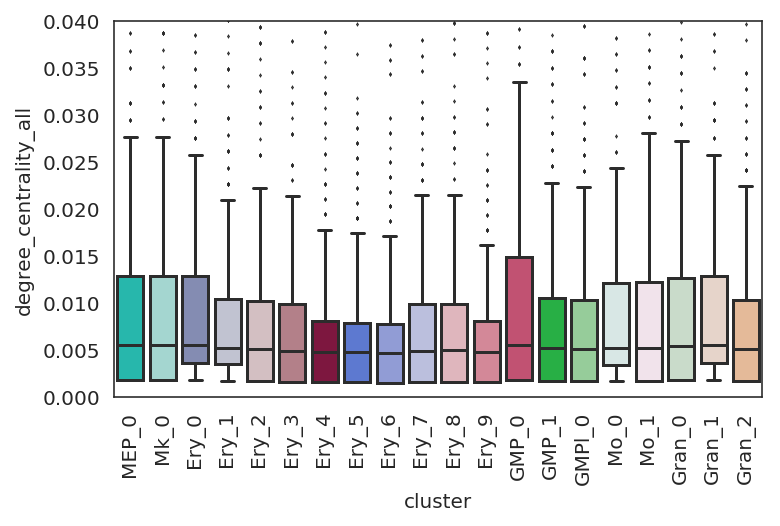

In [60]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot", save=f"{save_folder}")



eigenvector_centrality


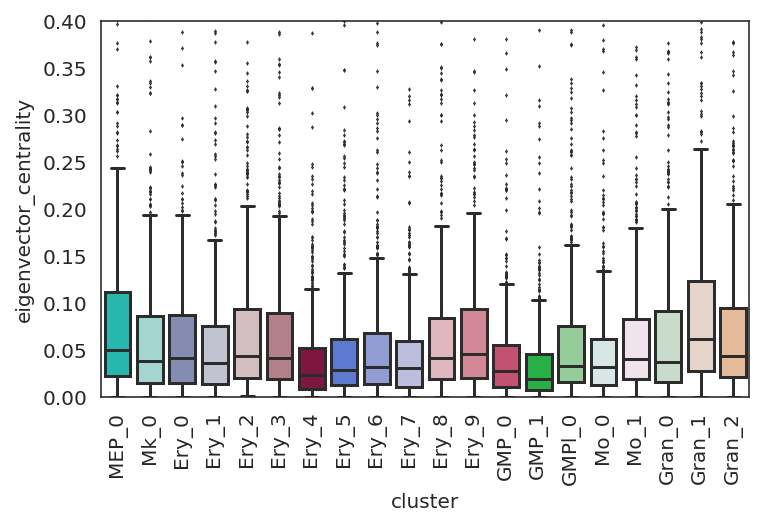

In [61]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.40])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot", save=f"{save_folder}")




## 8.2. Distribution of netowrk entropy

/home/k/anaconda3/envs/test/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2614: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
/home/k/anaconda3/envs/test/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py:345: RuntimeWarning: divide by zero encountered in log
  ent_norm.append(en/np.log(k[i]))
/home/k/anaconda3/envs/test/lib/python3.6/site-packages/celloracle/network_analysis/links_object.py:345: RuntimeWarning: invalid value encountered in double_scalars
  ent_norm.append(en/np.log(k[i]))


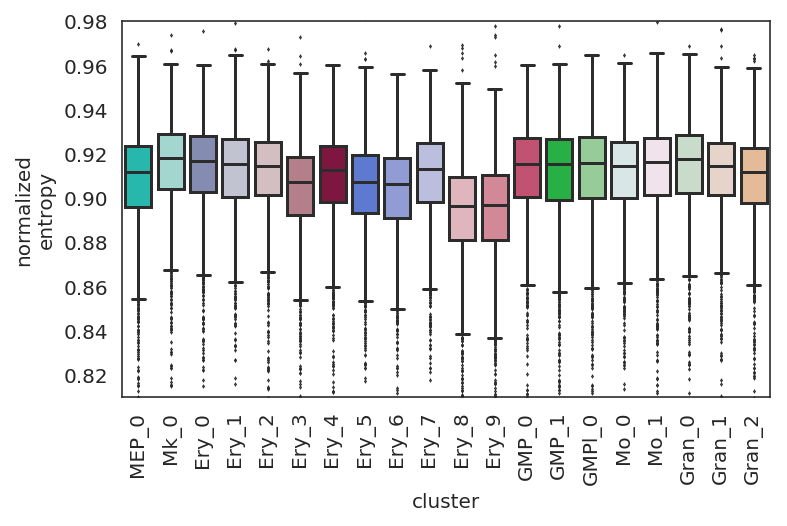

In [62]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")



Using the network scores, we could pick up cluster-specific key TFs.
Gata2, Gata1, Klf1, E2f1, for example, are known to play an essential role in MEP, and these TFs showed high network score in our GRN.

However, it is important to note that network analysis alone cannot shed light on the specific functions or roles these TFs play in cell fate determination. 

In the next section, we will begin to investigate each TF’s contribution to cell fate by running GRN simulations